# <font color=Brown> POS Tagging Using Modified Viterbi

## <font color=Green> Problem Statement
The problem aims at building a HMM-based POS tagger with implementation of the Viterbi algorithm using the Penn Treebank training corpus. The task is to write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words). Once this baseline model is achieved the model has to be evaluated on the validation set and POS tagging check has to be performed on the sample test sentences set. 


### <font color=Green> Approach:
(i) Solving the problem of unknown words using at least two techniques. These techniques can use any of the approaches - lexicon, rule-based, probabilistic etc. <br>
(ii) Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm. <br>
(iii) List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after modifications.

### <font color=Green>Step 1: Data Preparation

In [1]:
##Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##Importing all the necessary libraries
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, pprint
import random
from sklearn.model_selection import train_test_split
import time, pprint
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [3]:
##Reading the tagged sentences in Penn Treebank training corpus 
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
##Checking first few tagged sentences 
nltk_data[:20]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

#### <font color=Brown>Train Test Split 

##### <font color=Green>Note: The term 'test_set' here refers to the validation set. The actual test set corresponds to the corpus within the Sample Test Sentences text file.

In [5]:
##Splitting into train and test sets (using the pre-mentioned sample size of 95:5 for train and test sets respectively)
random.seed(42)
train_set, test_set = train_test_split(nltk_data, test_size= 0.05, random_state= 42)

print("Sentences in Train Set:", len(train_set))
print("Sentences in Test Set:", len(test_set)); print()

Sentences in Train Set: 3718
Sentences in Test Set: 196



In [6]:
##Checking the few tagged sentences in train_set after train_test_split
print(train_set[:10])  ##Top 10 tagged sentences

[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('were', 'VERB

In [7]:
## Getting list of tagged words
train_set_tagged_words = [tup for sent in train_set for tup in sent]
print(train_set_tagged_words[:10])  ##First 10 train_set_tagged_words
len(train_set_tagged_words)

[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP')]


95589

In [8]:
##Finding tokens from tagged words in the train_set 
tokens = [pair[0] for pair in train_set_tagged_words]

##Create a copy for later use
tokens_copy= tokens.copy()

print(tokens[:10])  ##First 10 tokens listed

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']


In [9]:
##Vocabulary
V = set(tokens) ##Unique tokens for vocabulary
print(len(V))

12109


In [10]:
##Checking few(first 10) words from vocabulary
print(list(V)[:10])

['ornamental', 'lengthen', 'rusted', '47.5', 'reorganization', 'strong-willed', 'photocopying', 'Funding', 'protected', 'Cougar']


In [11]:
##Number of POS tags in the corpus
T = sorted(set([pair[1] for pair in train_set_tagged_words]))  ##sorted POS tags within the corpus
print("POS Tags:", T)
len(T)

POS Tags: ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


12

The Universal tagset of `NLTK comprises only 12 coarse tag classes` as follows: `Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.`<br> <br>Therefore, `using only 12 coarse classes` (compared to the 46 fine classes such as NNP, VBD etc.); this will `make the Viterbi algorithm faster` as well.

### <font color=Green>Step 2: Build the vanilla Viterbi algorithm based POS tagger

##### <font color=Brown>(i.e. without dealing with unknown words)

#### <font color=Brown>Emission Probabilities (word| given tag) Instances

In [12]:
##Computing P(w/t) and storing in T x V matrix (Note: w: word and t:tag)
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
##Define a function to compute instances of a word given tag (i.e. for Emission Probability)
def word_given_tag(word, tag, my_train_bag = train_set_tagged_words):
    tag_list = [pair for pair in my_train_bag if pair[1]== tag]           ##Storing pairs with matching POS tags
    count_tag = len(tag_list)                                             ##Total matched tagged pairs
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0]== word]   ##List of pairs with matching word in the given tag list
    count_word_given_tag = len(word_given_tag_list)                             ##Count of word given tag
    
    return (count_word_given_tag, count_tag)

In [14]:
##Checking out Emission Probability function for an example.
print("Checking for word:", "\'management\'")
print(word_given_tag('management', 'NOUN'))
print(word_given_tag('management', 'PRON'))
print(word_given_tag('management', 'VERB'))

Checking for word: 'management'
(21, 27423)
(0, 2618)
(0, 12885)


The `Emission Probability (word| given tag) Instances` function works pretty well as we see that the emission probability for the word `'management'` aligns more towards `NOUN` as we do have matching instances of the same.

#### <font color=Brown>Transition Probabilities (tag t2| given tag t1) Instances
   

In [15]:
##Define a function to compute tag given tag instances: tag2(t2) given tag1 (t1), [i.e. for Transition Probability]

def t2_given_t1(t2, t1, my_train_bag = train_set_tagged_words):   
    tags_list = [pair[1] for pair in my_train_bag]
    tags_match_t1= [t for t in tags_list if t== t1]
    count_t1 = len(tags_match_t1)
    count_t2_t1 = 0
    for index in range(len(tags_list)-1):
        if tags_list[index]== t1 and tags_list[index+1] == t2:  ##when tag(t1) followed by tag(t2)
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
##Checking out Transition Probability Instances function with an example.
print(t2_given_t1(t2='NOUN', t1='ADJ'))   ##transition probability instances where an 'ADJ'(t1) followed by a 'NOUN'(t2)

(4234, 6077)


#### <font color=Brown>Transition Probabilities Matrix

Creating a `t x t transition matrix` of tags where each column is t2 and each row is t1. Thus, M(i, j) represents P(tj given ti).

In [17]:
##Transition Probability Matrix
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(T):     ##T is sorted POS Tag list 
    for j, t2 in enumerate(T): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]  ##transition probabilities within the matrix

In [18]:
tags_matrix

array([[9.38118398e-02, 4.49721180e-02, 9.11135077e-02, 5.20777106e-02,
        5.79240881e-02, 1.73502430e-01, 2.23151639e-01, 8.05000886e-02,
        6.53894618e-02, 2.33855005e-03, 8.85051265e-02, 2.66234931e-02],
       [6.53282851e-02, 6.66447282e-02, 7.89863393e-02, 4.60753683e-03,
        1.69491526e-02, 5.10120112e-03, 6.96725368e-01, 2.04048045e-02,
        6.58219506e-04, 1.08606219e-02, 1.23416157e-02, 2.13921349e-02],
       [3.94863561e-02, 1.05296947e-01, 1.72284637e-02, 1.31621184e-02,
        8.56072758e-04, 3.26377749e-01, 3.21776360e-01, 6.29213452e-02,
        6.91278726e-02, 1.49812736e-03, 8.23970046e-03, 3.40288915e-02],
       [1.36877075e-01, 1.30232558e-01, 1.19601332e-01, 8.10631216e-02,
        6.31229253e-03, 6.71096370e-02, 3.08970101e-02, 3.05647831e-02,
        1.56146176e-02, 1.36212623e-02, 3.44518274e-01, 2.35880390e-02],
       [3.42562161e-02, 1.16846554e-01, 5.44345379e-02, 5.58423288e-02,
        4.69263265e-04, 1.21539183e-01, 3.49131852e-01, 4.22

In [19]:
##Creating a dataframe to store the transition probabilities of the 12 tags (coarse classes) from the Universal tagset_nltk
tags_df = pd.DataFrame(tags_matrix, columns = T, index= T)
tags_df

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.093812,0.044972,0.091114,0.052078,0.057924,0.173502,0.223152,0.080500,0.065389,0.002339,0.088505,0.026623
ADJ,0.065328,0.066645,0.078986,0.004608,0.016949,0.005101,0.696725,0.020405,0.000658,0.010861,0.012342,0.021392
ADP,0.039486,0.105297,0.017228,0.013162,0.000856,0.326378,0.321776,0.062921,0.069128,0.001498,0.008240,0.034029
ADV,0.136877,0.130233,0.119601,0.081063,0.006312,0.067110,0.030897,0.030565,0.015615,0.013621,0.344518,0.023588
CONJ,0.034256,0.116847,0.054435,0.055842,0.000469,0.121539,0.349132,0.042234,0.058658,0.004693,0.153918,0.007977
DET,0.017986,0.204973,0.009054,0.012313,0.000483,0.005311,0.640029,0.021970,0.003742,0.000241,0.038387,0.045509
NOUN,0.239179,0.012289,0.176275,0.016884,0.041936,0.013310,0.264632,0.009627,0.004923,0.043832,0.147978,0.029136
NUM,0.118347,0.034196,0.034790,0.002974,0.013381,0.003271,0.355338,0.184062,0.001487,0.027951,0.017544,0.206661
PRON,0.041253,0.074866,0.022918,0.033995,0.004966,0.009549,0.211230,0.007257,0.008021,0.012223,0.480901,0.092819
PRT,0.041517,0.086303,0.021576,0.010134,0.002288,0.100360,0.242563,0.058516,0.018960,0.001635,0.402746,0.013403


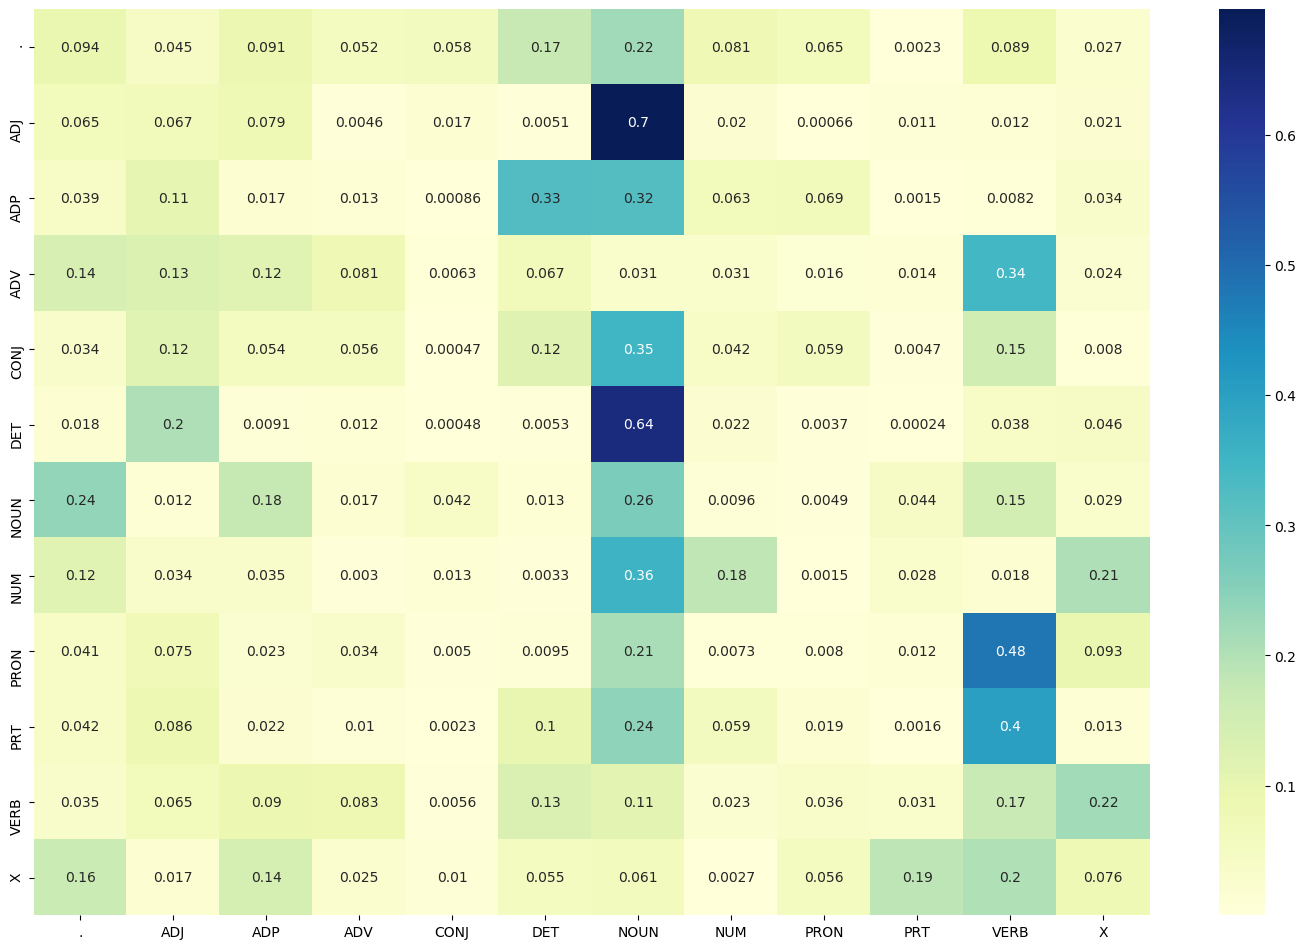

In [20]:
##Plot a heatmap of the tags_df matrix (transition probabilities)
plt.figure(figsize=(18, 12), dpi=100)
sns.heatmap(tags_df, cmap= "YlGnBu", annot= True)
plt.show()

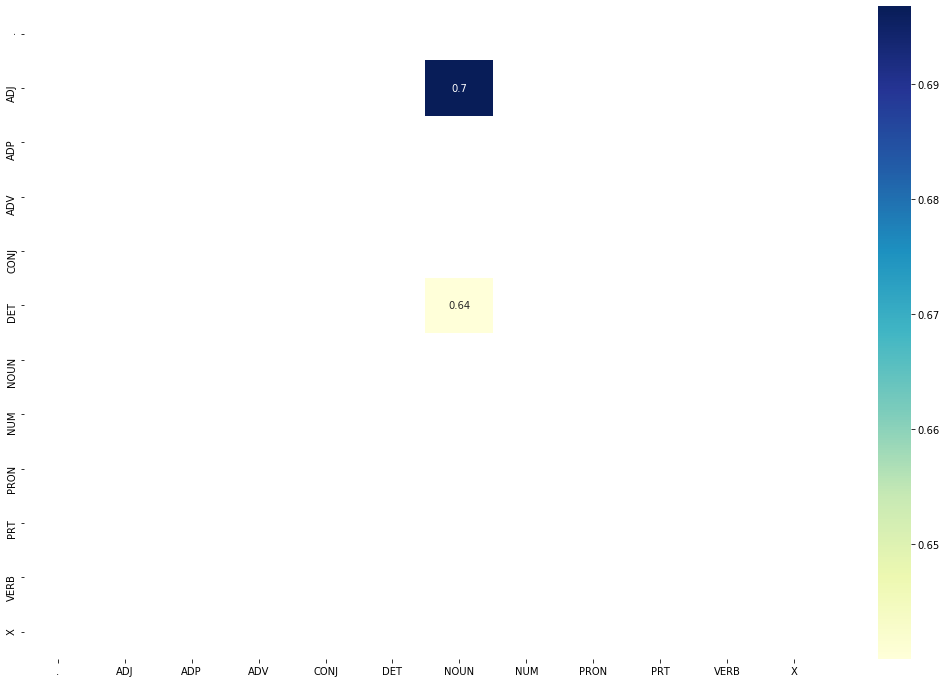

In [21]:
##Let's check transition probabilities greater than 50% (filter the df to get P(t2, t1) >50%)

tags_trans_p_50_plus = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_trans_p_50_plus, cmap= "YlGnBu", annot= True)
plt.show()

### <font color=Green>1. Unmodified Viterbi POS Tagger (vanilla version)

##### <font color=Brown>Function (1)

In [22]:
## Viterbi Algorithm (vanilla version)
def Viterbi(words, my_train_bag = train_set_tagged_words):
    state = []
    T = sorted(list(set([pair[1] for pair in my_train_bag])))  ##List of all unique tags within train_set_tagged_words
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p_instances= word_given_tag(words[key], tag)
            emission_p = emission_p_instances[0]/emission_p_instances[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### <font color=Green>Evaluating Tagging Accuracy (Validation Set): Viterbi (Vanilla)

In [23]:
##Let's test our Viterbi algorithm on our validation set (referred as test_set)
random.seed(42)

# list of all sentences selected
test_run = [sent for sent in test_set] 
test_run

[[('For', 'ADP'),
  ('the', 'DET'),
  ('Agency', 'NOUN'),
  ('for', 'ADP'),
  ('International', 'NOUN'),
  ('Development', 'NOUN'),
  (',', '.'),
  ('appropriators', 'NOUN'),
  ('approved', 'VERB'),
  ('$', '.'),
  ('200', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('in', 'ADP'),
  ('secondary', 'ADJ'),
  ('loan', 'NOUN'),
  ('guarantees', 'NOUN'),
  ('under', 'ADP'),
  ('an', 'DET'),
  ('expanded', 'VERB'),
  ('trade', 'NOUN'),
  ('credit', 'NOUN'),
  ('insurance', 'NOUN'),
  ('program', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('total', 'ADJ'),
  ('loan', 'NOUN'),
  ('guarantees', 'NOUN'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('Overseas', 'NOUN'),
  ('Private', 'NOUN'),
  ('Investment', 'NOUN'),
  ('Corp.', 'NOUN'),
  ('are', 'VERB'),
  ('increased', 'VERB'),
  ('*-3', 'X'),
  ('by', 'ADP'),
  ('$', '.'),
  ('40', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('over', 'ADP'),
  ('fiscal', 'ADJ'),
  ('1989', 'NUM'),
  ('as', 'ADP'),
  ('part', 'NOUN'),
  ('of', 'ADP'),
  ('

In [24]:
# list of tagged words (tuples from the validation set)
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_set_untagged_words = [tup[0] for sent in test_run for tup in sent]
print(test_set_untagged_words[:50])  ##print first 50

['For', 'the', 'Agency', 'for', 'International', 'Development', ',', 'appropriators', 'approved', '$', '200', 'million', '*U*', 'in', 'secondary', 'loan', 'guarantees', 'under', 'an', 'expanded', 'trade', 'credit', 'insurance', 'program', ',', 'and', 'total', 'loan', 'guarantees', 'for', 'the', 'Overseas', 'Private', 'Investment', 'Corp.', 'are', 'increased', '*-3', 'by', '$', '40', 'million', '*U*', 'over', 'fiscal', '1989', 'as', 'part', 'of', 'the']


In [25]:
##Tagging the test sentences
start = time.time()
tagged_sequence = Viterbi(test_set_untagged_words)
end = time.time()
difference = end-start
print("Time taken to tag the test sentences (in seconds): ", difference)

Time taken to tag the test sentences (in seconds):  671.3718938827515


In [26]:
##Display comparison of first 50 (word,tag) pairs of tagged sequence vs actual test_run_base 
print("Tagged Sequence using vanilla Viterbi Algorithm:\n\n", tagged_sequence[:50], "\n\n\n")
print("Actual Test Set:\n\n", test_run_base[:50])

Tagged Sequence using vanilla Viterbi Algorithm:

 [('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', '.'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET')] 



Actual Test Set:

 [('For', 'ADP')

In [27]:
##Finding the number of correct (word, tag) pairs
correct_matches = [i for i, j in zip(tagged_sequence, test_run_base) if i == j] 

##Computing the tagging accuracy (of Vanilla Viterbi POS tagger on validation set)
accuracy_score= len(correct_matches)/len(tagged_sequence)

print("Viterbi Algorithm (vanilla) Accuracy: ", accuracy_score)

Viterbi Algorithm (vanilla) Accuracy:  0.9138981718104974


In [28]:
##Few correctly tagged words pairs by Vanilla Viterbi 
print(correct_matches[:10])  ##first 10

[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.')]


In [29]:
##Incorrect tagged cases (format: [(previous_word, tag),(tag_seq_word, tag_seq_tag), (actual_word, actual_tag)])
incorrect_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_sequence, test_run_base)) if j[0]!=j[1]]
incorrect_cases[:20]  ##First 20 incorrectly tagged cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', '.'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', '.'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', '.'), ('Unemployment', 'NOUN'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', '.'), ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'), (('reasonably', '.'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('*-1', 'X'), (('Funded', '.'), ('Funded', 'VERB'))],
 [('from', 'ADP'), (('Tokio', '.'), ('Tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', '.'), ('protocols', 'NOUN'))],
 [('on', 'ADP'), (('preventative', '.'), ('preventative', 'ADJ'))],
 [('it', 'PRON'), (('existed', '.'), ('exi

In [30]:
##Incorrect tagged words with tags
incorrect_tagged_words =  [j[0] for i, j in enumerate(zip(tagged_sequence, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_words[:20]  ##First 20

[('trade', 'VERB'),
 ('Overseas', '.'),
 ('Private', 'ADJ'),
 ('pre-1917', '.'),
 ('Unemployment', '.'),
 ('purchasing', 'NOUN'),
 ('paycheck', '.'),
 ('reasonably', '.'),
 ('though', 'ADP'),
 ('close', 'NOUN'),
 ('more', 'ADV'),
 ('Funded', '.'),
 ('Tokio', '.'),
 ('protocols', '.'),
 ('preventative', '.'),
 ('existed', '.'),
 ('20.5', '.'),
 ('polarized', '.'),
 ('so', 'ADV'),
 ('exists', '.')]

**<font color=DarkGreen>Checking the `"Test_sentences.txt"` file to find out unknown words in the file<br>(unknown words imply the words that are not present in the Universal NLTK corpus but might be present in the Test_sentences.txt file)**

In [31]:
##Read 'Test_sentences.txt' file
with open("Test_sentences.txt", "r") as file:
    file_read= file.readlines()

file_read  ##Still contains '\n' and we can't use the sentence tokenizer directly as some lines don't end with a full-stop

['Android is a mobile operating system developed by Google.\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n',
 'Show me the cheapest round trips from Dallas to Atlanta\n',
 'I would like to see flights from Denver to Philadelphia.\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n',
 'NASA invited social medi

In [32]:
##Defining a function to eliminate the new lines '\n' from the sentences
def without_spaces_lines(my_list):
    list_lines=[]
    for item in file_read:
        item = re.sub("\n$","", item)
        list_lines.append(item)
    list_lines = [item for item in list_lines if item!='']
    return list_lines

text_lines = without_spaces_lines(file_read)  ##List of lines in the text file
text_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [33]:
##Entire Text
text_ = " ".join(text_lines)

In [34]:
##Tokenizing
test_tokens= nltk.tokenize.word_tokenize(text_)

#Copy of test_tokens
test_tokens_copy= test_tokens.copy()

print(test_tokens);print()  
print("Total Test Tokens:", len(test_tokens))

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [35]:
##Words not in corpus (Unknown Words)
tokens= tokens_copy
words_not_in_corpus = list(set(test_tokens).difference(set(tokens)))  ##unknown_words: difference between unique test_tokens and unique tokens from the training corpus
print("Unknown words in corpus:\n", words_not_in_corpus);print()
print("Number of Unknown words:",len(words_not_in_corpus))

Unknown words in corpus:
 ['arriving', 'tournament', 'domineering', 'ICESAT-2', 'Cup', 'FIFA', '2011', 'NASA', 'Android', 'OS', 'worldwide', 'firehose', 'tweets', 'Google', 'personality', '2018', 'smartphones', 'invited', '2013', 'online', 'messages', 'Satellite', 'trips', 'Twitter', '21st', 'contested', '2015', 'interact']

Number of Unknown words: 28


In [36]:
##Applying Vanilla Viterbi Algorithm (that was created without dealing with these unknown words)
test_file_words_tagged= Viterbi(test_tokens)
test_file_words_tagged

[('Android', '.'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', '.'),
 ('.', '.'),
 ('Android', '.'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', '.'),
 ('worldwide', '.'),
 ('on', 'ADP'),
 ('smartphones', '.'),
 ('since', 'ADP'),
 ('2011', '.'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', '.'),
 ('.', '.'),
 ('Google', '.'),
 ('and', 'CONJ'),
 ('Twitter', '.'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', '.'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', '.'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', '.'),
 ("'s", 'VERB'),
 ('firehose', '.'),
 ('.', '.'),
 ('Twitter', '.'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', '.'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which',

In [37]:
##Unknown words and their respective wrong POS tags checking using Vanilla Viterbi (not designed using these unknown words)
unknown_words_tags_van_vit= [tup for tup in test_file_words_tagged for word in words_not_in_corpus if tup[0]==word]
print(unknown_words_tags_van_vit)

[('Android', '.'), ('Google', '.'), ('Android', '.'), ('OS', '.'), ('worldwide', '.'), ('smartphones', '.'), ('2011', '.'), ('2013', '.'), ('Google', '.'), ('Twitter', '.'), ('2015', '.'), ('Google', '.'), ('Twitter', '.'), ('firehose', '.'), ('Twitter', '.'), ('online', '.'), ('interact', '.'), ('messages', '.'), ('tweets', '.'), ('domineering', '.'), ('personality', '.'), ('2018', '.'), ('FIFA', '.'), ('Cup', '.'), ('21st', '.'), ('FIFA', '.'), ('Cup', '.'), ('tournament', '.'), ('contested', '.'), ('Cup', '.'), ('trips', '.'), ('arriving', '.'), ('NASA', '.'), ('invited', '.'), ('ICESAT-2', '.'), ('Satellite', '.')]


In [38]:
##Unique set of unknown words and wrong POS tags assigned by vanilla Viterbi
unknown_words_tags_van_vit_uniq = sorted(list(set(unknown_words_tags_van_vit)))
print(unknown_words_tags_van_vit_uniq)

[('2011', '.'), ('2013', '.'), ('2015', '.'), ('2018', '.'), ('21st', '.'), ('Android', '.'), ('Cup', '.'), ('FIFA', '.'), ('Google', '.'), ('ICESAT-2', '.'), ('NASA', '.'), ('OS', '.'), ('Satellite', '.'), ('Twitter', '.'), ('arriving', '.'), ('contested', '.'), ('domineering', '.'), ('firehose', '.'), ('interact', '.'), ('invited', '.'), ('messages', '.'), ('online', '.'), ('personality', '.'), ('smartphones', '.'), ('tournament', '.'), ('trips', '.'), ('tweets', '.'), ('worldwide', '.')]


**Observation:**<br> All the unknown words in the sample sentences test file were naively tagged the first POS tag from the sorted POS tag list of Universal NLTK corpus i.e. `'.'`**(Punctuations)** was assigned to all unknown words by the vanilla Viterbi Algorithm. <br>This can be improved by making certain modifications to the vanilla Viterbi Algorithm.

### <font color=Green>Solving the problem of unknown words

Let's modify the Viterbi Algorithm to handle the unknown words. We shall be using two techniques.

### <font color=Brown>2. Viterbi Modification-Technique I: *(Viterbi_Modified_Technique_1)*

Method incorporated in `Viterbi_Modified_Technique_1`:<br>(i) `Probabilitisc approach` <br>(ii) `For words within the corpus`, computing the `state probability as (emission_probability)\*(transition probability)`<br>(iii) `For words not in the corpus`, computing the `state probability as (weight of tag)*(transition probability)`.<br> Note: We'll also be applying weights (for unknown words) based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words. <br>This scheme will also take into account some POS tags that are more likely to occur as compared to others.

In [39]:
##lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag_occ = len([tag for (word,tag) in train_set_tagged_words])  ##Total occurrences of all POS tags in the corpus

for t in T:  ##T is the unique set of POS Tags
    each_tag_occ = [tag for (word,tag) in train_set_tagged_words if tag==t]  ##Occurrence of each tag in the corpus
    tag_prob.append((t,len(each_tag_occ)/total_tag_occ))

##(tag, weight_based _on_occurrences)
tag_prob

[('.', 0.11631045413175156),
 ('ADJ', 0.06357426063668414),
 ('ADP', 0.09776229482471832),
 ('ADV', 0.03148897885739991),
 ('CONJ', 0.022293360114657546),
 ('DET', 0.08666269131385411),
 ('NOUN', 0.286884474154976),
 ('NUM', 0.035181872391174714),
 ('PRON', 0.02738808858759899),
 ('PRT', 0.032001590141125025),
 ('VERB', 0.1347958447101654),
 ('X', 0.0656560901358943)]

##### <font color=Brown>Function (2)

In [40]:
##Defining a function for Modified Viterbi 
def Viterbi_Modified_Technique_1(words, my_train_bag = train_set_tagged_words):
    state = []
    T = sorted(list(set([pair[1] for pair in my_train_bag])))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag] 
                
            # compute emission and state probabilities
            emission_p_instances= word_given_tag(words[key], tag)
            emission_p = emission_p_instances[0]/emission_p_instances[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)   
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p   ##(weight based on occurrences)*(transition_p)
            
            p_transition.append(transition_p)
            
            
        pmax = max(p)
    
        if(pmax == 0): ##if state probability is zero (because of zero emission probability for unknown word) 
            pmax = max(p_transition)  ##Use transition probability
            state_max = T[p_transition.index(pmax)]
        else:
            state_max = T[p.index(pmax)]
         
        state.append(state_max)
    return list(zip(words, state))

### <font color=Green>Evaluating the Tagging Accuracy (Validation Data): Modified Viterbi Technique 1

In [41]:
start = time.time()
tagged_sequence_1 = Viterbi_Modified_Technique_1(test_set_untagged_words)
end = time.time()
difference = end-start
print("Time taken to tag the test sentences (in seconds): ", difference)

Time taken to tag the test sentences (in seconds):  615.6852669715881


In [42]:
##Display comparison of first 50 (word,tag) pairs of tagged sequence 1 vs actual test_run_base 
print("Tagged Sequence using Modified Viterbi Technique 1:\n\n", tagged_sequence_1[:50], "\n\n\n")
print("Actual Test Set:\n\n", test_run_base[:50])

Tagged Sequence using Modified Viterbi Technique 1:

 [('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET')] 



Actual Test Set:

 [('For', 

In [43]:
##Finding the number of correct (word, tag) pairs
correct_matches_1 = [i for i, j in zip(tagged_sequence_1, test_run_base) if i == j] 

##Computing the POS Tagger's accuracy
accuracy_score_1 = len(correct_matches_1)/len(tagged_sequence_1)

print("Modified Viterbi Technique 1_POS Tagger's Accuracy: ", accuracy_score_1)

Modified Viterbi Technique 1_POS Tagger's Accuracy:  0.9425987812069982


In [44]:
##Display first few correct matches (first 10)
correct_matches_1[:10]

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.')]

In [45]:
##Incorrect tagged cases (format: [(previous_word, tag),(tag_seq_word, tag_seq_tag), (actual_word, actual_tag)])
incorrect_cases_mod_1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_sequence_1, test_run_base)) if j[0]!=j[1]]
incorrect_cases_mod_1[:20]  ##First 20

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'NOUN'), ('pre-1917', 'ADJ'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('paycheck', 'NOUN'), (('reasonably', 'NOUN'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('on', 'ADP'), (('preventative', 'NOUN'), ('preventative', 'ADJ'))],
 [('$', '.'), (('20.5', 'NOUN'), ('20.5', 'NUM'))],
 [('become', 'VERB'), (('polarized', 'NOUN'), ('polarized', 'VERB'))],
 [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))],
 [('a', 'DET'), (('middle', 'NOUN'), ('middle', 'ADJ'))],
 [('.', '.'), (('Though', 'NOUN'), ('Though', 'ADP'))],
 [('totaled', 'VERB'), (('154.2', 'NOUN'), ('154.2', 'NUM'))],
 [('chalk', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 

In [46]:
##Incorrect tagged words
incorrect_tagged_words_mod_1 =  [j[0] for i, j in enumerate(zip(tagged_sequence_1, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_words_mod_1[:20]  ##First 20

[('trade', 'VERB'),
 ('Private', 'ADJ'),
 ('pre-1917', 'NOUN'),
 ('purchasing', 'NOUN'),
 ('reasonably', 'NOUN'),
 ('though', 'ADP'),
 ('close', 'NOUN'),
 ('more', 'ADV'),
 ('preventative', 'NOUN'),
 ('20.5', 'NOUN'),
 ('polarized', 'NOUN'),
 ('so', 'ADV'),
 ('middle', 'NOUN'),
 ('Though', 'NOUN'),
 ('154.2', 'NOUN'),
 ('first', 'ADJ'),
 ('touched', 'NOUN'),
 ('cross-border', 'NOUN'),
 ('*T*-133', 'NOUN'),
 ('checking', 'NOUN')]

#### <font color=DarkGreen> Checking POS Tagging of unknown words in `Test_sentences.txt` (Sample Sentences Test Txt file) using **Viterbi_Modified_Technique_1**<br>

In [47]:
##Words not in corpus (Unknown Words)
tokens= tokens_copy
words_not_in_corpus = list(set(test_tokens) - set(tokens))
print("Unknown words in corpus:\n", words_not_in_corpus);print()
print("Number of Unknown words:",len(words_not_in_corpus))

Unknown words in corpus:
 ['arriving', 'tournament', 'domineering', 'ICESAT-2', 'Cup', 'FIFA', '2011', 'NASA', 'Android', 'OS', 'worldwide', 'firehose', 'tweets', 'Google', 'personality', '2018', 'smartphones', 'invited', '2013', 'online', 'messages', 'Satellite', 'trips', 'Twitter', '21st', 'contested', '2015', 'interact']

Number of Unknown words: 28


In [48]:
##Applying 'Viterbi_Modified_Technique_1' 
test_tokens= test_tokens_copy
test_file_words_tagged_1 = Viterbi_Modified_Technique_1(test_tokens)
test_file_words_tagged_1

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

In [49]:
##Unknown words and their respective POS tags checking using 'Viterbi_Modified_Technique_1' 
unknown_words_tags_1= [tup for tup in test_file_words_tagged_1 for word in words_not_in_corpus if tup[0]==word]
print(unknown_words_tags_1)

[('Android', 'NOUN'), ('Google', 'NOUN'), ('Android', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('smartphones', 'NOUN'), ('2011', 'NOUN'), ('2013', 'NOUN'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('2015', 'NOUN'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('firehose', 'NOUN'), ('Twitter', 'NOUN'), ('online', 'NOUN'), ('interact', 'NOUN'), ('messages', 'NOUN'), ('tweets', 'NOUN'), ('domineering', 'NOUN'), ('personality', 'NOUN'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('Cup', 'NOUN'), ('trips', 'NOUN'), ('arriving', 'NOUN'), ('NASA', 'NOUN'), ('invited', 'NOUN'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [50]:
unknown_words_tags_1_uniq = sorted(list(set(unknown_words_tags_1)))
print(unknown_words_tags_1_uniq)

[('2011', 'NOUN'), ('2013', 'NOUN'), ('2015', 'NOUN'), ('2018', 'NOUN'), ('21st', 'NOUN'), ('Android', 'NOUN'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Google', 'NOUN'), ('ICESAT-2', 'NOUN'), ('NASA', 'NOUN'), ('OS', 'NOUN'), ('Satellite', 'NOUN'), ('Twitter', 'NOUN'), ('arriving', 'NOUN'), ('contested', 'NOUN'), ('domineering', 'NOUN'), ('firehose', 'NOUN'), ('interact', 'NOUN'), ('invited', 'NOUN'), ('messages', 'NOUN'), ('online', 'NOUN'), ('personality', 'NOUN'), ('smartphones', 'NOUN'), ('tournament', 'NOUN'), ('trips', 'NOUN'), ('tweets', 'NOUN'), ('worldwide', 'NOUN')]


In [51]:
##Zip original and modified viterbi technique 1 (for comparison)
orig_mod_viterbi_1 = sorted(list(set(zip(unknown_words_tags_van_vit_uniq, unknown_words_tags_1_uniq))))  
orig_mod_viterbi_1

[(('2011', '.'), ('2011', 'NOUN')),
 (('2013', '.'), ('2013', 'NOUN')),
 (('2015', '.'), ('2015', 'NOUN')),
 (('2018', '.'), ('2018', 'NOUN')),
 (('21st', '.'), ('21st', 'NOUN')),
 (('Android', '.'), ('Android', 'NOUN')),
 (('Cup', '.'), ('Cup', 'NOUN')),
 (('FIFA', '.'), ('FIFA', 'NOUN')),
 (('Google', '.'), ('Google', 'NOUN')),
 (('ICESAT-2', '.'), ('ICESAT-2', 'NOUN')),
 (('NASA', '.'), ('NASA', 'NOUN')),
 (('OS', '.'), ('OS', 'NOUN')),
 (('Satellite', '.'), ('Satellite', 'NOUN')),
 (('Twitter', '.'), ('Twitter', 'NOUN')),
 (('arriving', '.'), ('arriving', 'NOUN')),
 (('contested', '.'), ('contested', 'NOUN')),
 (('domineering', '.'), ('domineering', 'NOUN')),
 (('firehose', '.'), ('firehose', 'NOUN')),
 (('interact', '.'), ('interact', 'NOUN')),
 (('invited', '.'), ('invited', 'NOUN')),
 (('messages', '.'), ('messages', 'NOUN')),
 (('online', '.'), ('online', 'NOUN')),
 (('personality', '.'), ('personality', 'NOUN')),
 (('smartphones', '.'), ('smartphones', 'NOUN')),
 (('tournament

In [52]:
##Check if the pairs within a tuple are similar in nature or not
[j for i,j in enumerate(orig_mod_viterbi_1) if j[0]==j[1]]

[]

In [53]:
##Check for modified POS tags in 'unknown_words_tags_1_uniq'
Counter([tup[1] for tup in unknown_words_tags_1_uniq]).most_common()

[('NOUN', 28)]

In [54]:
##Modified Cases
##Nouns
noun_words= sorted(list(set([tup[0] for tup in unknown_words_tags_1_uniq if tup[1]=='NOUN'])))
print("Words_Tagged_[Nouns]:\n", noun_words); print()

Words_Tagged_[Nouns]:
 ['2011', '2013', '2015', '2018', '21st', 'Android', 'Cup', 'FIFA', 'Google', 'ICESAT-2', 'NASA', 'OS', 'Satellite', 'Twitter', 'arriving', 'contested', 'domineering', 'firehose', 'interact', 'invited', 'messages', 'online', 'personality', 'smartphones', 'tournament', 'trips', 'tweets', 'worldwide']



**Observations:**<br>
In case of Probabilistic Tagger, the algorithm assigns the most probable tag (in this case, `NOUN`) to the unknown words.<br>
*Modified Viterbi Algorithm Technique 1 shows some improvement in tagging the words with correct POS tags.*<br><br>
Correct `POS tagged Nouns`: `'Android', 'smartphones', 'firehose', 'Satellite', 'messages', 'tournament', 'personality', 'tweets', 'Cup', 'trips', 'ICESAT-2', 'Twitter', 'Google', 'FIFA', 'OS', 'NASA'`*


### <font color=Brown>3. Viterbi Modification-Technique II: *(Viterbi_Modified_Technique_2)*

Method that would be incorporated in `Modified Viterbi Algorithm 2`:<br>(i) Multiple Taggers Combined: `Lexicon(Trigram, Bigram, Unigram), Affix, Rule-Based Taggers, and Default Tagger` (in that order where Default Tagger: Tagging the most common POS tag to the unknown words in the corpus).<br>(ii) The Rule-Based Tagger also takes into account most of the morphological cues necessary for proper POS tagging of words.

In [55]:
##Default Tag in the Universal NLTK corpus (for assigning the DefaultTag in case all tags fail to identify)
from collections import Counter

tags = [pair[1] for pair in train_set_tagged_words]
tag_counts = Counter(tags).most_common()
tag_counts[:1]  ##Most common tag identified in the train corpus

[('NOUN', 27423)]

**Observation:** The most common tag within the training corpus is `NOUN`. This shall be used within the last backoff `Default Tagger`.

In [56]:
##Rule-Based Tagger: (Taking into account the morphological cues)

##Specify patterns (for Regexp): Rule based tagging 
##Example from the NLTK book
patterns = [
    (r"[0-9]+(st|nd|rd|th)$", 'ADJ'),    #For adjectives like 1st, 2nd, 3rd, 4th, 50th, etc.
    (r"[\*\w-]*\*+[\*\w-]*$", 'X'),      #Others/Foreignwords(bearing at least one *)
    (r'.*ing$', 'VERB'),                 # gerund
    (r'.*ed$', 'VERB'),                  # past tense verbs
    (r'.*es$', 'VERB'),                  # singular present verbs
    (r'.*ould$', 'VERB'),                # modal verbs
    (r'.*\'s$', 'NOUN'),                 # possessive nouns
    (r'.*s$', 'NOUN'),                   # plural nouns
    (r"\*T?\*?-[0-9]+$", "X"),           #Cases: Others
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),    # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),    # articles or determinants
    (r'.*able$', 'ADJ'),                 # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                   # adverbs
]

In [57]:
##Defining a 'pos_tagger' function for the Taggers to used in Technique 2: (Lexicon + Rule_Based + DefaultTagger)
random.seed(42)
def pos_tagger(train_set):
    rule_based_tagger = nltk.RegexpTagger(patterns, backoff=nltk.DefaultTagger('NOUN'))
    affix_tagger = nltk.AffixTagger(train_set, backoff= rule_based_tagger)
    unigram_tagger = nltk.UnigramTagger(train_set, backoff= affix_tagger)
    bigram_tagger = nltk.BigramTagger(train_set, backoff= unigram_tagger)
    trigram_tagger = nltk.TrigramTagger(train_set, backoff= bigram_tagger)
    return trigram_tagger

tagger= pos_tagger(train_set) ##Instantiating the tagger object

##### <font color=Brown> Function (3)

In [58]:
##Defining a function for Modified Viterbi Technique 2
def Viterbi_Modified_Technique_2(words, my_train_bag = train_set_tagged_words):
    state = []
    T = sorted(list(set([pair[1] for pair in my_train_bag])))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p_instances= word_given_tag(words[key], tag)
            emission_p = emission_p_instances[0]/emission_p_instances[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if(pmax == 0):
            state_max = tagger.tag([word])[0][1]  ##Using tagger.tag() generated from the pos_tagger to get the POS tag          
        else: 
            state_max = T[p.index(pmax)]
         
        state.append(state_max)
    return list(zip(words, state))

### <font color=Green>Evaluating the Tagging Accuracy (Validation Data): Modified Viterbi Technique 2

In [59]:
start = time.time()
tagged_sequence_2 = Viterbi_Modified_Technique_2(test_set_untagged_words)
end = time.time()
difference = end-start
print("Time taken to tag the test sentences (in seconds): ", difference)

Time taken to tag the test sentences (in seconds):  625.6503756046295


In [60]:
##Display comparison of first 50 (word,tag) pairs of tagged sequence 2 vs actual test_run_base 
print("Tagged Sequence using Modified Viterbi Technique 2:\n\n", tagged_sequence_2[:50], "\n\n\n")
print("Actual Test Set:\n\n", test_run_base[:50])

Tagged Sequence using Modified Viterbi Technique 2:

 [('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET')] 



Actual Test Set:

 [('For', 

In [61]:
##Finding the number of correct (word, tag) pairs
correct_matches_2 = [i for i, j in zip(tagged_sequence_2, test_run_base) if i == j] 

##Computing the POS Tagger's accuracy
accuracy_score_2 = len(correct_matches_2)/len(tagged_sequence_2)

print("Modified Viterbi Technique 2_POS Tagger's Accuracy: ", accuracy_score_2)

Modified Viterbi Technique 2_POS Tagger's Accuracy:  0.9581285630037351


In [62]:
##First few correct matches- (word, tag) pairs (using Modified Viterbi Technique 2)
correct_matches_2[:10]

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.')]

In [63]:
##Incorrect tagged cases (format: [(previous_word, tag),(tag_seq_word, tag_seq_tag), (actual_word, actual_tag)])
incorrect_cases_mod_2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_sequence_2, test_run_base)) if j[0]!=j[1]]
incorrect_cases_mod_2[:20]  ##First 20

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'NOUN'), ('pre-1917', 'ADJ'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', 'VERB'), ('paycheck', 'NOUN'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))],
 [('*ICH*-2', 'X'), (('exists', 'NOUN'), ('exists', 'VERB'))],
 [('a', 'DET'), (('middle', 'NOUN'), ('middle', 'ADJ'))],
 [('chalk', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('on', 'ADP'), (('cross-border', 'NOUN'), ('cross-border', 'ADJ'))],
 [('included', 'VERB'), (('checking', 'NOUN'), ('checking', 'VERB'))],
 [(',', '.'), (('safe', 'NOUN'), ('safe', 'ADJ'))],
 [('--', '.'), (('plus', 'CONJ'), ('plus', 'ADV'))],
 [('the', 

In [64]:
##Incorrect tagged words
incorrect_tagged_words_mod_2 =  [j[0] for i, j in enumerate(zip(tagged_sequence_2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_words_mod_2[:20]  ##First 20

[('trade', 'VERB'),
 ('Private', 'ADJ'),
 ('pre-1917', 'NOUN'),
 ('purchasing', 'NOUN'),
 ('paycheck', 'VERB'),
 ('though', 'ADP'),
 ('close', 'NOUN'),
 ('more', 'ADV'),
 ('so', 'ADV'),
 ('exists', 'NOUN'),
 ('middle', 'NOUN'),
 ('first', 'ADJ'),
 ('cross-border', 'NOUN'),
 ('checking', 'NOUN'),
 ('safe', 'NOUN'),
 ('plus', 'CONJ'),
 ('homeless', 'ADJ'),
 ('pre-existing', 'VERB'),
 ('up', 'ADV'),
 ('American-style', 'NOUN')]

#### <font color=DarkGreen> Checking POS Tagging of unknown words in `Test_sentences.txt` (Sample Sentences Test Txt file) using **Viterbi_Modified_Technique_2**<br>

In [65]:
##Words not in corpus (Unknown Words)
tokens= tokens_copy
words_not_in_corpus = list(set(test_tokens) - set(tokens))
print("Unknown words in corpus:\n", words_not_in_corpus);print()
print("Number of Unknown words:",len(words_not_in_corpus))

Unknown words in corpus:
 ['arriving', 'tournament', 'domineering', 'ICESAT-2', 'Cup', 'FIFA', '2011', 'NASA', 'Android', 'OS', 'worldwide', 'firehose', 'tweets', 'Google', 'personality', '2018', 'smartphones', 'invited', '2013', 'online', 'messages', 'Satellite', 'trips', 'Twitter', '21st', 'contested', '2015', 'interact']

Number of Unknown words: 28


In [66]:
##Applying 'Viterbi_Modified_Technique_2' 
test_tokens= test_tokens_copy
test_file_words_tagged_2 = Viterbi_Modified_Technique_2(test_tokens)
test_file_words_tagged_2

[('Android', 'VERB'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADJ'),
 ('.', '.'),
 ('Android', 'VERB'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'VERB'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'ADJ'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'DET'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('servi

In [67]:
##Unknown words and their respective POS tags checking using 'Viterbi_Modified_Technique_2' 
unknown_words_tags_2= [tup for tup in test_file_words_tagged_2 for word in words_not_in_corpus if tup[0]==word]
print(unknown_words_tags_2)

[('Android', 'VERB'), ('Google', 'ADJ'), ('Android', 'VERB'), ('OS', 'NOUN'), ('worldwide', 'VERB'), ('smartphones', 'NOUN'), ('2011', 'NUM'), ('2013', 'NUM'), ('Google', 'ADJ'), ('Twitter', 'NOUN'), ('2015', 'NUM'), ('Google', 'ADJ'), ('Twitter', 'NOUN'), ('firehose', 'DET'), ('Twitter', 'NOUN'), ('online', 'NOUN'), ('interact', 'NOUN'), ('messages', 'NOUN'), ('tweets', 'NOUN'), ('domineering', 'VERB'), ('personality', 'NOUN'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('21st', 'ADJ'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('Cup', 'NOUN'), ('trips', 'NOUN'), ('arriving', 'VERB'), ('NASA', 'NOUN'), ('invited', 'VERB'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [68]:
unknown_words_tags_2_uniq = sorted(list(set(unknown_words_tags_2)))
print(unknown_words_tags_2_uniq)

[('2011', 'NUM'), ('2013', 'NUM'), ('2015', 'NUM'), ('2018', 'NUM'), ('21st', 'ADJ'), ('Android', 'VERB'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Google', 'ADJ'), ('ICESAT-2', 'NOUN'), ('NASA', 'NOUN'), ('OS', 'NOUN'), ('Satellite', 'NOUN'), ('Twitter', 'NOUN'), ('arriving', 'VERB'), ('contested', 'VERB'), ('domineering', 'VERB'), ('firehose', 'DET'), ('interact', 'NOUN'), ('invited', 'VERB'), ('messages', 'NOUN'), ('online', 'NOUN'), ('personality', 'NOUN'), ('smartphones', 'NOUN'), ('tournament', 'NOUN'), ('trips', 'NOUN'), ('tweets', 'NOUN'), ('worldwide', 'VERB')]


In [69]:
##Zip original and modified viterbi technique 2 (for comparison)
orig_mod_viterbi_2 = sorted(list(set(zip(unknown_words_tags_van_vit_uniq, unknown_words_tags_2_uniq))))  
orig_mod_viterbi_2

[(('2011', '.'), ('2011', 'NUM')),
 (('2013', '.'), ('2013', 'NUM')),
 (('2015', '.'), ('2015', 'NUM')),
 (('2018', '.'), ('2018', 'NUM')),
 (('21st', '.'), ('21st', 'ADJ')),
 (('Android', '.'), ('Android', 'VERB')),
 (('Cup', '.'), ('Cup', 'NOUN')),
 (('FIFA', '.'), ('FIFA', 'NOUN')),
 (('Google', '.'), ('Google', 'ADJ')),
 (('ICESAT-2', '.'), ('ICESAT-2', 'NOUN')),
 (('NASA', '.'), ('NASA', 'NOUN')),
 (('OS', '.'), ('OS', 'NOUN')),
 (('Satellite', '.'), ('Satellite', 'NOUN')),
 (('Twitter', '.'), ('Twitter', 'NOUN')),
 (('arriving', '.'), ('arriving', 'VERB')),
 (('contested', '.'), ('contested', 'VERB')),
 (('domineering', '.'), ('domineering', 'VERB')),
 (('firehose', '.'), ('firehose', 'DET')),
 (('interact', '.'), ('interact', 'NOUN')),
 (('invited', '.'), ('invited', 'VERB')),
 (('messages', '.'), ('messages', 'NOUN')),
 (('online', '.'), ('online', 'NOUN')),
 (('personality', '.'), ('personality', 'NOUN')),
 (('smartphones', '.'), ('smartphones', 'NOUN')),
 (('tournament', '.')

In [70]:
##Check if the pairs within a tuple are similar in nature or not
[j for i,j in enumerate(orig_mod_viterbi_2) if j[0]==j[1]]

[]

In [71]:
##Check for modified POS tags in 'unknown_words_tags_1_uniq'
Counter([tup[1] for tup in unknown_words_tags_2_uniq]).most_common()

[('NOUN', 15), ('VERB', 6), ('NUM', 4), ('ADJ', 2), ('DET', 1)]

In [72]:
##Modified Cases
#(i) Nouns
noun_words= sorted(set([tup[0] for tup in unknown_words_tags_2_uniq if tup[1]=='NOUN']))
print("Words_Tagged_[Nouns]:\n", noun_words); print()

#(ii) Verbs
verb_words= sorted(set([tup[0] for tup in unknown_words_tags_2_uniq if tup[1]=='VERB']))
print("Words_Tagged_[Verbs]:\n", verb_words); print()

#(iii) Num
numbers= sorted(set([tup[0] for tup in unknown_words_tags_2_uniq if tup[1]=='NUM']))
print("Tagged_[Numbers]:\n", numbers); print()

#(iv) Adjective
adj= sorted(set([tup[0] for tup in unknown_words_tags_2_uniq if tup[1]=='ADJ']))
print("Tagged_[Adjectives]:\n", adj); print()

#(v) Determiners
det= sorted(set([tup[0] for tup in unknown_words_tags_2_uniq if tup[1]=='DET']))
print("Tagged_[Determiners]:\n", det); print()

Words_Tagged_[Nouns]:
 ['Cup', 'FIFA', 'ICESAT-2', 'NASA', 'OS', 'Satellite', 'Twitter', 'interact', 'messages', 'online', 'personality', 'smartphones', 'tournament', 'trips', 'tweets']

Words_Tagged_[Verbs]:
 ['Android', 'arriving', 'contested', 'domineering', 'invited', 'worldwide']

Tagged_[Numbers]:
 ['2011', '2013', '2015', '2018']

Tagged_[Adjectives]:
 ['21st', 'Google']

Tagged_[Determiners]:
 ['firehose']



**Observations:**<br>
*Modified Viterbi Algorithm shows a drastic improvement in POS tagging of most of the words with correct POS tags.*<br><br>(i) All unknown `numbers` were tagged correctly by  Modified Viterbi Technique 2 Model. Example: `'2011', '2013', '2015', '2018'` : All were correctly tagged as `NUM`<br>(ii) Correct `POS tagged Verbs`: `'arriving', 'contested','domineering','invited'`<br>(iii) Correct `POS tagged Nouns`: `'FIFA', 'Cup', 'ICESAT-2', 'NASA', 'OS', 'Satellite', 'Twitter', 'messages', 'personality', 'smartphones', 'tournament','trips', 'tweets'.`<br>(iv) Correctly `POS tagged Adjectives`: `21st`

# <font color=Green>Conclusion

### <font color=Purple>Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [73]:
##Storing accuracies and improvements in variables
acc= round(100*accuracy_score,4)
acc_1= round(100*accuracy_score_1,4)
acc_2= round(100*accuracy_score_2,4)
imp_1= acc_1- acc  ##Improvement in Technique 1  and Technique 2 w.r.t. baseline Viterbi model
imp_2= acc_2 - acc

##Creating a dataframe 'performance_df' to store performance metrics
performance_df= pd.DataFrame({'Model No.':list(range(1,4)),'Model':['Unmodified Viterbi POS Tagger (Baseline Model)',\
                            'Viterbi Modified Technique 1', 'Viterbi Modified Technique 2'], 'POS Tagger\'s Accuracy (%)': \
                             [acc, acc_1, acc_2],\
                             '%Improvement (w.r.t. Baseline Model)':['-',imp_1, imp_2]})
performance_df.set_index('Model No.', inplace= True)
performance_df

,Model,POS Tagger's Accuracy (%),%Improvement (w.r.t. Baseline Model)
Model No.,,,
1,Unmodified Viterbi POS Tagger (Baseline Model),91.3898,-
2,Viterbi Modified Technique 1,94.2599,2.8701
3,Viterbi Modified Technique 2,95.8129,4.4231


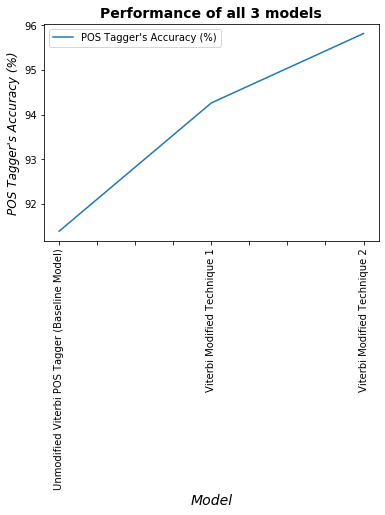

In [74]:
##Performance of all the 3 models (Displaying evaluation tagging accuracies)
%matplotlib inline
performance_df_plot= performance_df[['Model','POS Tagger\'s Accuracy (%)']]
performance_df_plot.set_index('Model', inplace= True)
performance_df_plot.plot.line(rot= 90)
plt.title("Performance of all 3 models", fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize="14", fontstyle='italic')
plt.ylabel('POS Tagger\'s Accuracy (%)', fontsize="12", fontstyle='italic')
plt.show()

**Observations:**<br>The graph and the table above clearly shows an `increase` in the performance of the models `(increase in tagging accuracy)` as we incorporate modifications within the baseline Vanilla Viterbi algorithm.

### <font color=Purple>List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### <font color=Brown>1. Viterbi (Baseline) Original POS Tagger: Incorrectly Tagged Words (Unknown Words):

In [75]:
##Unknown words (with Incorrect Tags: Baseline Viterbi): 
print(unknown_words_tags_van_vit_uniq)

[('2011', '.'), ('2013', '.'), ('2015', '.'), ('2018', '.'), ('21st', '.'), ('Android', '.'), ('Cup', '.'), ('FIFA', '.'), ('Google', '.'), ('ICESAT-2', '.'), ('NASA', '.'), ('OS', '.'), ('Satellite', '.'), ('Twitter', '.'), ('arriving', '.'), ('contested', '.'), ('domineering', '.'), ('firehose', '.'), ('interact', '.'), ('invited', '.'), ('messages', '.'), ('online', '.'), ('personality', '.'), ('smartphones', '.'), ('tournament', '.'), ('trips', '.'), ('tweets', '.'), ('worldwide', '.')]


**Observation:** All unknown words were incorrectly tagged with the first tag as `'.'`**(Punctuations)** by Viterbi (Baseline) Model.

#### <font color=Brown>Comparing the incorrect tags of unknown words (from Baseline Viterbi) with the assigned POS tags obtained from other two models.

### <font color=DarkGreen>2. Model: Viterbi Modification-Technique I (Modified Viterbi Technique 1)

In [76]:
##List of unique unknown words and POS Tags (using Modified Viterbi Technique 1))
print(unknown_words_tags_1_uniq)

[('2011', 'NOUN'), ('2013', 'NOUN'), ('2015', 'NOUN'), ('2018', 'NOUN'), ('21st', 'NOUN'), ('Android', 'NOUN'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Google', 'NOUN'), ('ICESAT-2', 'NOUN'), ('NASA', 'NOUN'), ('OS', 'NOUN'), ('Satellite', 'NOUN'), ('Twitter', 'NOUN'), ('arriving', 'NOUN'), ('contested', 'NOUN'), ('domineering', 'NOUN'), ('firehose', 'NOUN'), ('interact', 'NOUN'), ('invited', 'NOUN'), ('messages', 'NOUN'), ('online', 'NOUN'), ('personality', 'NOUN'), ('smartphones', 'NOUN'), ('tournament', 'NOUN'), ('trips', 'NOUN'), ('tweets', 'NOUN'), ('worldwide', 'NOUN')]


<font color=Purple>**SAMPLE (TEST) CASES: CORRECTED BY MODIFICATIONS 1 w.r.t. BASELINE VITERBI:**<br></font>
*Modified Viterbi Algorithm Technique 1 shows some improvement in tagging the words with correct POS tags.*<br><br>
Correct `POS tagged Nouns`: `'Android', 'smartphones', 'firehose', 'Satellite', 'messages', 'tournament', 'personality', 'tweets', 'Cup', 'trips', 'ICESAT-2', 'Twitter', 'Google', 'FIFA', 'OS', 'NASA'`*<br>
<br>
<font color=Purple>**LIST OF 3 CASES TAGGED CORRECTLY IN COMPARISON TO BASELINE POS TAGGER:**<br></font>
1\. ('Satellite', 'NOUN'): 'Satellite' was correctly tagged as 'NOUN' (where the baseline Viterbi incorrectly tagged it as '.')<br>
2\. ('smartphones', 'NOUN'): 'smartphones' was correctly tagged as 'NOUN' (where the baseline Viterbi incorrectly tagged it as '.')<br>
3\. ('tournament', 'NOUN'): 'tournament' was correctly tagged as 'NOUN' (where the baseline Viterbi incorrectly tagged it as '.')
<br>


### <font color=DarkGreen>3. Model: Viterbi Modification-Technique II (Modified Viterbi Technique 2)

In [77]:
##List of unique unknown words and POS Tags (using Modified Viterbi Technique 2)
print(unknown_words_tags_2_uniq)

[('2011', 'NUM'), ('2013', 'NUM'), ('2015', 'NUM'), ('2018', 'NUM'), ('21st', 'ADJ'), ('Android', 'VERB'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Google', 'ADJ'), ('ICESAT-2', 'NOUN'), ('NASA', 'NOUN'), ('OS', 'NOUN'), ('Satellite', 'NOUN'), ('Twitter', 'NOUN'), ('arriving', 'VERB'), ('contested', 'VERB'), ('domineering', 'VERB'), ('firehose', 'DET'), ('interact', 'NOUN'), ('invited', 'VERB'), ('messages', 'NOUN'), ('online', 'NOUN'), ('personality', 'NOUN'), ('smartphones', 'NOUN'), ('tournament', 'NOUN'), ('trips', 'NOUN'), ('tweets', 'NOUN'), ('worldwide', 'VERB')]


<font color=Purple>**SAMPLE (TEST) CASES: CORRECTED BY MODIFICATION 2 w.r.t. BASELINE VITERBI:**<br></font>
*Modified Viterbi Algorithm shows a drastic improvement in POS tagging of most of the words with correct POS tags.*<br><br>(i) All unknown `numbers` were tagged correctly by  Modified Viterbi Technique 2 Model. Example: `'2011', '2013', '2015', '2018'` : All were correctly tagged as `NUM`<br>(ii) Correct `POS tagged Verbs`: `'arriving', 'contested','domineering','invited'`<br>(iii) Correct `POS tagged Nouns`: `'FIFA', 'Cup', 'ICESAT-2', 'NASA', 'OS', 'Satellite', 'Twitter', 'messages', 'personality', 'smartphones', 'tournament','trips', 'tweets'.`<br>(iv) Correctly `POS tagged Adjectives`: `21st`

<font color=Purple>**LIST OF 3 CASES TAGGED CORRECTLY IN COMPARISON TO BASELINE POS TAGGER:**<br></font>
1\. ('NASA', 'NOUN'): 'NASA' was correctly tagged as 'NOUN' (where the baseline Viterbi incorrectly tagged it as '.')<br>
2\. ('contested', 'VERB'): 'contested' was correctly tagged as 'VERB' (where the baseline Viterbi incorrectly tagged it as '.')<br>
3\. ('2011','NUM'): '2011' was correctly tagged as 'NUM' (where the baseline Viterbi incorrectly tagged it as '.')<br>
